# Predcition of Hospital Admission Related to Sinusitis

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to sinusitis. We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [202]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import scipy.stats as st
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [203]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [204]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [205]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'sinusitis_date_'+str(i), 'sinusitis_ab_date_'+str(i), 'sinusitis_ab_type_'+str(i),
                   'incdt_sinusitis_date_'+str(i), 'admitted_sinusitis_date_'+str(i), 'sgss_gp_cov_sinusitis_date_'+str(i)]]
    
    #drop rows with no sinusitis reord
    datum = datum[datum['sinusitis_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with sinusitis_i
    datum = datum[datum['sgss_gp_cov_sinusitis_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'sinusitis_date_'+str(i): 'sinusitis_date', 'sinusitis_ab_date_'+str(i): 'sinusitis_ab_date', 
                           'sinusitis_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_sinusitis_date_'+str(i): 'incdt_sinusitis_date', 'incdt_sinusitis_type_'+str(i): 'incdt_sinusitis_type',
                           'admitted_sinusitis_date_'+str(i): 'admitted_sinusitis_date',
                           'sgss_gp_cov_sinusitis_date_'+str(i): 'sgss_gp_cov_sinusitis_date'},
                inplace=True)
    
    return datum

In [206]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred):

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_tot = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit']]], axis=1)

    #calculate sums
    summary_table = prob_pred_enc_tot.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_tot.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_tot.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [207]:
#summary table of baseline characteristics
def make_summary_table_deciles(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_deciles_'+infection+'_'+infection_type+'.csv', index=False)

In [208]:
def cox_build(infection, infection_type, data, data_no_abs):
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_sinusitis_admitted',
            event_col='event_sinusitis_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_sinusitis_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a columns of risk factors, prescribed antibiotics, and hosp event 
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit', 'ab_binary', 'event_'+infection+'_admitted']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary', 'event_'+infection+'_admitted']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count', 'event_'+infection+'_admitted_mean', 'event_'+infection+'_admitted_sum', 'event_'+infection+'_admitted_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_urti_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [264]:
def lr_rf_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)

    #save prob_pred for analysis in r
    prob_pred.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_lr_rf_'+infection+'_'+infection_type+'_r_analysis.csv', index=False)

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #drop 1st column to take it as reference group
    prob_pred_enc = prob_pred_enc.iloc[: , 1:]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    #save prob_pred_enc_lr_rf for analysis in r
    prob_pred_enc_lr_rf.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_lr_rf_'+infection+'_'+infection_type+'_r_analysis_binned.csv', index=False)

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    #building lr model
    lr = LogisticRegression(solver="saga", random_state=42).fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict_proba(data_enc_dev_x)[:,1]
    lr_pred_val = lr.predict_proba(data_enc_val_x)[:,1]

    # ##building rf model
    # rf = RandomForestClassifier()#n_estimators=500, max_leaf_nodes=50, max_depth=50)
    # rf.fit(data_enc_dev_x, data_enc_dev_y)
    # #predict probabilities to rf model
    # rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    # rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #calculate aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    # auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    # auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    # print('AUROC of RF for deciles with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #caculate ORs and intervals of LR model, save and print them 
    # lr_coef = pd.DataFrame({"or": lr.coef_})#, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    # lr_coef_exp = np.exp(lr_coef)
    # lr_coef_exp.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_deciles_'+infection+'_'+infection_type+'.csv')
    # lr_coef = lr.coef_
    # print('LR ORs:\n %s'%(lr_coef))
    # lr_coef = pd.DataFrame(data=np.exp(lr.coef_), index=data_enc_dev_x.columns, columns=['lr_coef'])
    # lr_coef = lr_coef.sort_values('lr_coef', ascending=False)
    # lr_coef = pd.DataFrame(data=lr.coef_.T, index=data_enc_dev_x.columns, columns=['lr_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # # lr_coef['lr_coef_lower_bound'] = st.norm.ppf(lr_coef['lr_coef'])
    alpha = 0.05
    #the coefficients of the regression model
    coefs = np.r_[lr.coef_.T.tolist()]#[lr.intercept_], lr.coef_.T.tolist()
    #build an auxiliary dataframe with the constant term in it
    X_aux = data_enc_dev_x.copy()
    # X_aux.insert(0, 'const', 1)
    #degrees of freedom
    dof = -np.diff(X_aux.shape)[0]
    #Student's t-distribution table lookup
    t_val = stats.t.isf(alpha/2, dof)
    #MSE of the residuals
    mse = np.sum((data_enc_dev_y['ab_binary'].to_numpy() - lr.predict(data_enc_dev_x)) ** 2) / dof
    #inverse of the variance of the parameters
    var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
    #distance between lower and upper bound of CI
    gap = t_val * np.sqrt(mse * var_params)
    lr_coef_ors_ints = pd.DataFrame({'coef': coefs.ravel(), 'coef_lower': coefs.ravel() - gap, 'coef_upper': coefs.ravel() + gap}, index=X_aux.columns)
    lr_coef_ors_ints[['ors', 'ors_lower', 'ors_upper']] = np.exp(lr_coef_ors_ints[['coef', 'coef_lower', 'coef_upper']])
    # lr_coef_ors_ints = lr_coef_ors_ints.sort_values('coef', ascending=False)
    lr_coef_ors_ints.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    print('LR ORs:\n %s'%(lr_coef_ors_ints))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    # #print feature importance of RF model
    # rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    # rf_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_deciles_'+infection+'_'+infection_type+'.csv')
    # print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    # r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    # r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    # line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    # line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR model with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val#, rf_pred_dev, rf_pred_val

In [266]:
def lr_rf_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']].columns)
    #drop ref columns
    prob_pred_enc = prob_pred_enc[['age_cat_25_34', 'age_cat_35_44', 'age_cat_45_54', 'age_cat_55_64', 'age_cat_65_74', 'age_cat_75_more', #'age_cat_15_24', 
                                   'sex_male', #'sex_female', 
                                   'CCI_cat_high', 'CCI_cat_low', 'CCI_cat_medium', 'CCI_cat_very_high', #'CCI_cat_very_low', 
                                   'flu_vaccine_yes', #'flu_vaccine_no',
                                   'bmi_cat_obese', 'bmi_cat_overweight', 'bmi_cat_underweight', 'bmi_cat_unknown', #'bmi_cat_healthy_weight',
                                   'region_yorkshire', 'region_east_midlands', 'region_london', 'region_north_east', 'region_north_west', 'region_south_east', 'region_south_west', 'region_west_midlands', #'region_east', 
                                   'imd_very_unaffluent', 'imd_medium', 'imd_affluent', 'imd_very_affluent', 'imd_unknown', #'imd_unaffluent',
                                   'ethnicity_asian', 'ethnicity_other', 'ethnicity_unknown', 'ethnicity_mixed', 'ethnicity_black', #'ethnicity_white', 
                                   'smoking_smoker', 'smoking_never_smoked', 'smoking_unknown', #'smoking_ex_smoker', 
                                   'season_spring', 'season_summer', 'season_winter', #'season_autumn',
                                   ]]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    #building lr model
    lr = LogisticRegression(solver="saga", random_state=42).fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict_proba(data_enc_dev_x)[:,1]
    lr_pred_val = lr.predict_proba(data_enc_val_x)[:,1]

    # ##building rf model
    # rf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, max_depth=50)
    # rf.fit(data_enc_dev_x, data_enc_dev_y)
    # #predict probabilities to rf model
    # rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    # rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    # auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    # auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    # print('AUROC of RF for risk factors with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    # #print summary of LR model
    # lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    # lr_coef = np.exp(lr_coef)
    # lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    # print('LR coefficients:\n %s'%(lr_coef))
    alpha = 0.05
    #the coefficients of the regression model
    coefs = np.r_[lr.coef_.T.tolist()] #[lr.intercept_], lr.coef_.T.tolist()
    #build an auxiliary dataframe with the constant term in it
    X_aux = data_enc_dev_x.copy()
   #  X_aux.insert(0, 'const', 1)
    #degrees of freedom
    dof = -np.diff(X_aux.shape)[0]
    #Student's t-distribution table lookup
    t_val = stats.t.isf(alpha/2, dof)
    #MSE of the residuals
    mse = np.sum((data_enc_dev_y['ab_binary'].to_numpy() - lr.predict(data_enc_dev_x)) ** 2) / dof
    #inverse of the variance of the parameters
    var_params = np.diag(np.linalg.inv(X_aux.T.dot(X_aux)))
    #distance between lower and upper bound of CI
    gap = t_val * np.sqrt(mse * var_params)
    lr_coef_ors_ints = pd.DataFrame({'coef': coefs.ravel(), 'coef_lower': coefs.ravel() - gap, 'coef_upper': coefs.ravel() + gap}, index=X_aux.columns)
    lr_coef_ors_ints[['ors', 'ors_lower', 'ors_upper']] = np.exp(lr_coef_ors_ints[['coef', 'coef_lower', 'coef_upper']])
    # lr_coef_ors_ints = lr_coef_ors_ints.sort_values('coef', ascending=False)
    lr_coef_ors_ints.to_csv('../output/hospitalisation_prediction_'+infection+'/ors_lr_'+infection+'_'+infection_type+'.csv')
    print('LR ORs:\n %s'%(lr_coef_ors_ints))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    # #print feature importance of RF model
    # rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    # rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    # lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    # print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    # r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    # r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    # line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    # line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val#, rf_pred_dev, rf_pred_val

In [211]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val):#, rf_pred_dev, rf_pred_val):
    # ##calibration for RF
    # rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    # #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    # rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    # #merge cumulative hazards with their actual events (0, 1)
    # rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    # #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    # rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    # rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    # #calculate proportion of events in each bin
    # rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    # #
    # rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    # #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    # rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    # #merge cumulative hazards with their actual events (0, 1)
    # rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    # #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    # rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    # rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    # #calculate proportion of events in each bin
    # rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    # #plot calibration plot for RF model with development and validation data
    # fig, ax1 = plt.subplots(figsize=(7, 7))
    # plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    # plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    # plt.xlabel('Mean predicted probabilities', fontsize=14)
    # plt.ylabel('Proportion of observed values', fontsize=14)
    # plt.xticks(fontsize=12)
    # plt.yticks(fontsize=12, rotation=0)
    # plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    # plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    # plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    # plt.title("Calibration plot of RF model", fontsize=14)
    # legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    # legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    # plt.legend(handles=[legend_dev, legend_val])
    # plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    # plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [212]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_sinusitis.csv.gz')

In [213]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [214]:
#process 20 sinusitiss and concatenate them 
data_sinusitis_1 = proc_infec_data(data,1)
data_sinusitis_2 = proc_infec_data(data,2)
data_sinusitis_3 = proc_infec_data(data,3)
data_sinusitis_4 = proc_infec_data(data,4)
data_sinusitis_5 = proc_infec_data(data,5)
data_sinusitis_6 = proc_infec_data(data,6)
data_sinusitis_7 = proc_infec_data(data,7)
data_sinusitis_8 = proc_infec_data(data,8)
data_sinusitis_9 = proc_infec_data(data,9)
data_sinusitis_10 = proc_infec_data(data,10)
data_sinusitis_11 = proc_infec_data(data,11)
data_sinusitis_12 = proc_infec_data(data,12)
data_sinusitis_13 = proc_infec_data(data,13)
data_sinusitis_14 = proc_infec_data(data,14)
data_sinusitis_15 = proc_infec_data(data,15)
data_sinusitis_16 = proc_infec_data(data,16)
data_sinusitis_17 = proc_infec_data(data,17)
data_sinusitis_18 = proc_infec_data(data,18)
data_sinusitis_19 = proc_infec_data(data,19)
data_sinusitis_20 = proc_infec_data(data,20)

data_sinusitis = pd.concat([data_sinusitis_1, data_sinusitis_2, data_sinusitis_3, data_sinusitis_4, data_sinusitis_5, data_sinusitis_6, data_sinusitis_7, data_sinusitis_8, data_sinusitis_9, data_sinusitis_10, data_sinusitis_11, data_sinusitis_12, data_sinusitis_13, data_sinusitis_14, data_sinusitis_15, data_sinusitis_16, data_sinusitis_17, data_sinusitis_18, data_sinusitis_19, data_sinusitis_20])
data_sinusitis.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [215]:
##add variable season
#convert data types
data_sinusitis['sinusitis_date'] = data_sinusitis['sinusitis_date'].astype('datetime64[ns]')
data_sinusitis['admitted_sinusitis_date'] = data_sinusitis['admitted_sinusitis_date'].astype('datetime64[ns]')
data_sinusitis.died_date = data_sinusitis.died_date.astype('datetime64[ns]')
data_sinusitis.deregistered_date = data_sinusitis.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_sinusitis['date'] = data_sinusitis['sinusitis_date'] 
data_sinusitis['date'] = data_sinusitis['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_sinusitis with today's date in year and month
data_sinusitis = data_sinusitis[data_sinusitis['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_sinusitis = data_sinusitis[data_sinusitis['date'] != last_1_month_date_y_m]
data_sinusitis = data_sinusitis[data_sinusitis['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of sinusitis records
data_sinusitis['season'] = np.nan
data_sinusitis['date_month'] = pd.DatetimeIndex(data_sinusitis['date']).month

conditions = [
    (data_sinusitis['date_month'] >= 3) & (data_sinusitis['date_month'] <= 5),
    (data_sinusitis['date_month'] >= 6) & (data_sinusitis['date_month'] <= 8),
    (data_sinusitis['date_month'] >= 9) & (data_sinusitis['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_sinusitis['season'] = np.select(conditions, choices, default='winter')

In [216]:
#add variable time period
data_sinusitis.loc[(data_sinusitis['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_sinusitis.loc[((data_sinusitis['date'] >= '2020-05') & (data_sinusitis['date'] <= '2021-04')), 'period'] = 'during_pandemic'
data_sinusitis.loc[(data_sinusitis['date'] >= '2021-05'), 'period'] = 'post_2nd_lockdown'

In [217]:
data_sinusitis['date'].max()

'2023-04'

#### event and duration

In [218]:
#scenario 1
#not hosped (nothing happened)
data_sinusitis.loc[data_sinusitis['admitted_sinusitis_date'].isnull(), 'event_sinusitis_admitted'] = 0

In [219]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_sinusitis['delta_sinusitis_admitted'] = (data_sinusitis['admitted_sinusitis_date'] - data_sinusitis['sinusitis_date']).dt.days
data_sinusitis.loc[((data_sinusitis['delta_sinusitis_admitted'] >= 0) & (data_sinusitis['delta_sinusitis_admitted'] <= 30)), 'event_sinusitis_admitted'] = 1

#scenario 2
#drop whoever was admitted before sinusitis consultation, i.e. negative value for delta_sinusitis_admitted
data_sinusitis = data_sinusitis[~(data_sinusitis['delta_sinusitis_admitted'] < 0)]

In [220]:
#scenario 3
#censor died patients
data_sinusitis['delta_admitted_died'] = (data_sinusitis['died_date'] - data_sinusitis['admitted_sinusitis_date']).dt.days
data_sinusitis.loc[data_sinusitis['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_sinusitis.loc[((data_sinusitis['delta_admitted_died'] >= 0) & (data_sinusitis['delta_admitted_died'] <= 30)), 'event_sinusitis_admitted'] = 0

#scenario 3
#censor deregistered patients
data_sinusitis['delta_admitted_deregistered'] = (data_sinusitis['deregistered_date'] - data_sinusitis['admitted_sinusitis_date']).dt.days
data_sinusitis.loc[data_sinusitis['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_sinusitis.loc[((data_sinusitis['delta_admitted_deregistered'] > 0) & (data_sinusitis['delta_admitted_deregistered'] <= 30)), 'event_sinusitis_admitted'] = 0

#agg scenario 3s
data_sinusitis['delta_admitted_died_deregistered'] = data_sinusitis['delta_admitted_deregistered'].combine_first(data_sinusitis['delta_admitted_died'])
data_sinusitis.loc[data_sinusitis['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [221]:
#scenario 1
#any other patients (nothing happened)
data_sinusitis['event_sinusitis_admitted'] = data_sinusitis['event_sinusitis_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_sinusitis['duration_sinusitis_admitted'] = data_sinusitis['delta_sinusitis_admitted'].combine_first(data_sinusitis['delta_admitted_died_deregistered'])
data_sinusitis['duration_sinusitis_admitted'] = data_sinusitis['duration_sinusitis_admitted'].replace(np.NaN, 30)
data_sinusitis.loc[(data_sinusitis['duration_sinusitis_admitted'] > 30), 'duration_sinusitis_admitted'] = 30

#give value 1 to event_sinusitis_admitted if duration_sinusitis_admitted is greater or equal to 0 and less than 30
data_sinusitis.loc[((data_sinusitis['duration_sinusitis_admitted'] >= 0) & (data_sinusitis['duration_sinusitis_admitted'] < 30)), 'event_sinusitis_admitted'] = 1

#drop any rows with value 0 in duration column
data_sinusitis = data_sinusitis[~(data_sinusitis['duration_sinusitis_admitted'] == 0)]

In [222]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_sinusitis.loc[((data_sinusitis['delta_sinusitis_admitted'] > 0) & (data_sinusitis['delta_sinusitis_admitted'] < 30)), 'event_sinusitis_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [223]:
#drop anybody with age less than 18 or 0!
data_sinusitis = data_sinusitis[~(data_sinusitis['age'] < 18)] 
data_sinusitis['age'][data_sinusitis['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_sinusitis = data_sinusitis[data_sinusitis['age_cat'] != '0-4']
data_sinusitis = data_sinusitis[data_sinusitis['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_sinusitis['bmi'][data_sinusitis['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_sinusitis['bmi'] = data_sinusitis['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_sinusitis['antibacterial_brit'][data_sinusitis['antibacterial_brit'] < 0] = np.nan

In [224]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_sinusitis = data_sinusitis.replace({"sex": dict_sex})
data_sinusitis = data_sinusitis.replace({"smoking": dict_smoking})

In [225]:
#drop rows with missing region
if ('region' in data_sinusitis.columns) and (data_sinusitis['region'].isnull().sum() > 0):
   data_sinusitis = data_sinusitis[data_sinusitis['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_sinusitis.columns) and (data_sinusitis['antibacterial_brit'].isnull().sum() > 0):
    data_sinusitis['antibacterial_brit'] = data_sinusitis['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_sinusitis.columns) and (data_sinusitis['ethnicity'].isnull().sum() > 0):
    data_sinusitis['ethnicity'] = data_sinusitis['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_sinusitis.columns) and (data_sinusitis['smoking'].isnull().sum() > 0):
    data_sinusitis['smoking'] = data_sinusitis['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_sinusitis.columns) and (data_sinusitis['imd'].isnull().sum() > 0):
    data_sinusitis['imd'] = data_sinusitis['imd'].fillna(0)

In [226]:
#missing values of bmi assign 5 and 0; categorise bmi
data_sinusitis['bmi_cat'] = 5

for idx, x in enumerate(data_sinusitis['bmi_cat']):
    if data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] >= 30:
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] >= 25) and (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] < 30):
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] >= 18.5) and (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] < 25):
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] < 18.5:
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_sinusitis.columns) and (data_sinusitis['bmi_cat'].isnull().sum() > 0):
    data_sinusitis['bmi_cat'] = data_sinusitis['bmi_cat'].fillna(0)

In [227]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_sinusitis.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_sinusitis['ab_type_cat'] = np.where(data_sinusitis['ab_type'].isin(ab_series[mask].index),'other',data_sinusitis['ab_type'])
#assign no to non ab users
data_sinusitis.loc[data_sinusitis['sinusitis_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_sinusitis['ab_type_cat'] = data_sinusitis['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [228]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_sinusitis = data_sinusitis.replace({"sex": dict_sex})
data_sinusitis = data_sinusitis.replace({"ethnicity": dict_ethnicity})
data_sinusitis = data_sinusitis.replace({"smoking": dict_smoking})
data_sinusitis = data_sinusitis.replace({"imd": dict_imd})
data_sinusitis = data_sinusitis.replace({"bmi_cat": dict_bmi})
data_sinusitis = data_sinusitis.replace({"flu_vaccine": dict_flu})
data_sinusitis = data_sinusitis.replace({"region": dict_region})
data_sinusitis = data_sinusitis.replace({"age_cat": dict_age})
data_sinusitis = data_sinusitis.replace({"ab_type_cat": dict_ab_type})

In [229]:
data_sinusitis.ethnicity.value_counts('NA')

white      0.601395
unknown    0.248013
other      0.075592
asian      0.075000
Name: ethnicity, dtype: float64

In [230]:
data_sinusitis.smoking.value_counts('NA')

unknown         0.414259
smoker          0.391468
never_smoked    0.130156
ex_smoker       0.064116
Name: smoking_status, dtype: float64

In [231]:
data_sinusitis.bmi_cat.value_counts('NA')

obese             0.522310
unknown           0.251821
overweight        0.110477
healthy_weight    0.082883
underweight       0.032509
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [232]:
#categorise CCI
data_sinusitis['CCI_cat'] = pd.cut(data_sinusitis['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_sinusitis['antibacterial_brit'].clip(0, data_sinusitis['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

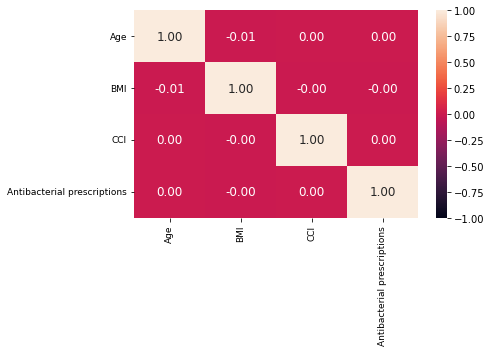

In [233]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_sinusitis[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_sinusitis/corr_sinusitis.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [234]:
data_sinusitis = data_sinusitis[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'sinusitis_ab_date', 'ab_type_cat', 'incdt_sinusitis_date', 'date', 'period',
                                   'event_sinusitis_admitted', 'duration_sinusitis_admitted'
                                    ]]

In [235]:
#switch variable sinusitis_ab_date into a binary variable
data_sinusitis[['ab_binary']] = data_sinusitis[['sinusitis_ab_date']].where(data_sinusitis[['sinusitis_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_sinusitis_incdt = data_sinusitis[data_sinusitis['incdt_sinusitis_date'] == 0]
data_sinusitis_prevl = data_sinusitis[data_sinusitis['incdt_sinusitis_date'] == 1]

#no antibiotics and incident hospital admission
data_sinusitis_no_abs_incdt = data_sinusitis_incdt[data_sinusitis_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_sinusitis_abs_incdt = data_sinusitis_incdt[data_sinusitis_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_sinusitis_no_abs_prevl = data_sinusitis_prevl[data_sinusitis_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_sinusitis_abs_prevl = data_sinusitis_prevl[data_sinusitis_prevl['ab_binary'] == 1]

In [236]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_sinusitis_incdt_prepandemic = data_sinusitis_incdt[data_sinusitis_incdt['period'] == 'prepandemic']
data_sinusitis_incdt_during_pandemic = data_sinusitis_incdt[(data_sinusitis_incdt['period'] == 'during_pandemic')]
data_sinusitis_incdt_post_2nd_lockdown = data_sinusitis_incdt[data_sinusitis_incdt['period'] == 'post_2nd_lockdown']
data_sinusitis_prevl_prepandemic = data_sinusitis_prevl[data_sinusitis_prevl['period'] == 'prepandemic']
data_sinusitis_prevl_during_pandemic = data_sinusitis_prevl[(data_sinusitis_prevl['period'] == 'during_pandemic')]
data_sinusitis_prevl_post_2nd_lockdown = data_sinusitis_prevl[data_sinusitis_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_sinusitis_no_abs_incdt_prepandemic = data_sinusitis_incdt_prepandemic[data_sinusitis_incdt_prepandemic['ab_binary'] == 0]
data_sinusitis_no_abs_incdt_during_pandemic = data_sinusitis_incdt_during_pandemic[data_sinusitis_incdt_during_pandemic['ab_binary'] == 0]
data_sinusitis_no_abs_incdt_post_2nd_lockdown = data_sinusitis_incdt_post_2nd_lockdown[data_sinusitis_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_sinusitis_no_abs_prevl_prepandemic = data_sinusitis_prevl_prepandemic[data_sinusitis_prevl_prepandemic['ab_binary'] == 0]
data_sinusitis_no_abs_prevl_during_pandemic = data_sinusitis_prevl_during_pandemic[data_sinusitis_prevl_during_pandemic['ab_binary'] == 0]
data_sinusitis_no_abs_prevl_post_2nd_lockdown = data_sinusitis_prevl_post_2nd_lockdown[data_sinusitis_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [237]:
#store data for plotting hosp admission counts and percentages
%store data_sinusitis
# save data
data_sinusitis.to_csv('../output/hospitalisation_prediction_sinusitis/data_sinusitis.csv')

Stored 'data_lrti' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-0- summary tables

In [238]:
#make summary tables
make_summary_table('sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt)
make_summary_table('sinusitis', 'abs_incdt', data_sinusitis_abs_incdt)
make_summary_table('sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl)
make_summary_table('sinusitis', 'abs_prevl', data_sinusitis_abs_prevl)

### 5-1- incident

<lifelines.CoxPHFitter: fitted with 109932 total observations, 109234 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 109932
number of events observed = 698
   partial log-likelihood = -8081.10
         time fit was run = 2023-07-21 17:26:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.13       0.88       0.11            -0.34             0.09                 0.71                 1.09
CCI_cat[T.medium]               -0.00       1.00       0.12            -0.24             0.23                 0.79                 1.26
CCI_cat[T.high]                 -0.09       0.91       0.15            -0.38             0.20                 0.68                 1.22
CCI_cat[T.very_high]            -0.06       0.94       0.13            -0.31             0.19                 0.73                 1.21
age_cat[T.25_34]                -0.03       0.97       0.14            -0.30             0.24                 0.74                 1.27
age_cat[T.35_44]                -0.02       0.98       0.14            -0.28             0.25                 0.75                 1.29
age_cat[T.45_54]                -0.10       0.91       0.14            -0.37             0.18                 0.69                 1.20
age_cat[T.55_64]                -0.23       0.79       0.14            -0.52             0.05                 0.60                 1.05
age_cat[T.65_74]                -0.16       0.85       0.14            -0.44             0.12                 0.65                 1.13
age_cat[T.75_more]              -0.01       0.99       0.14            -0.28             0.26                 0.76                 1.29
antibacterial_brit               0.02       1.02       0.03            -0.03             0.07                 0.97                 1.08
bmi_cat[T.obese]                 0.27       1.30       0.16            -0.04             0.57                 0.96                 1.77
bmi_cat[T.overweight]            0.28       1.32       0.19            -0.08             0.64                 0.92                 1.90
bmi_cat[T.underweight]           0.45       1.57       0.24            -0.02             0.92                 0.98                 2.51
bmi_cat[T.unknown]               0.19       1.21       0.17            -0.14             0.52                 0.87                 1.67
ethnicity[T.other]               0.17       1.19       0.20            -0.21             0.56                 0.81                 1.75
ethnicity[T.unknown]             0.16       1.18       0.16            -0.16             0.48                 0.86                 1.62
ethnicity[T.white]               0.07       1.08       0.15            -0.23             0.38                 0.80                 1.46
flu_vaccine[T.yes]               0.28       1.32       0.11             0.06             0.51                 1.06                 1.66
imd[T.medium]                    0.11       1.11       0.12            -0.13             0.35                 0.88                 1.41
imd[T.unaffluent]                0.19       1.20       0.12            -0.05             0.42                 0.95                 1.52
imd[T.unknown]                  -0.13       0.88       0.21            -0.53             0.28                 0.59                 1.32
imd[T.very_affluent]            -0.11       0.89       0.13            -0.36             0.14                 0.69                 1.15
imd[T.very_unaffluent]           0.02       1.02       0.12            -0.22             0.26                 0.80                 1.30
region[T.east_midlands]          0.07       1.07       0.17      

13045


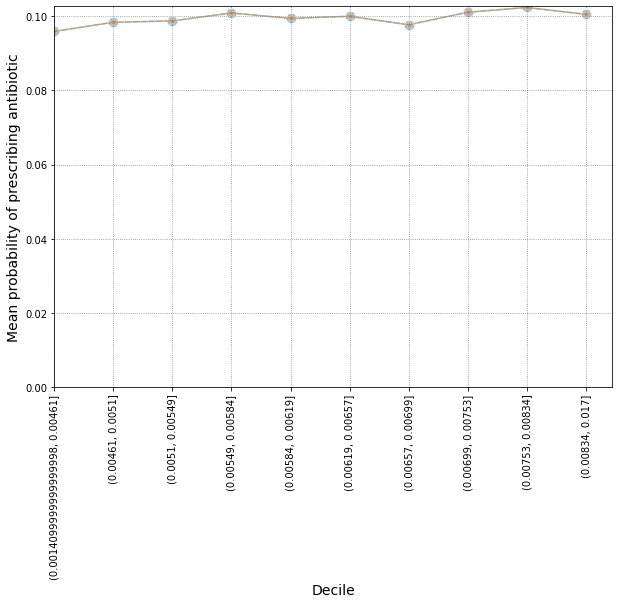


AUROC of LR for deciles with development and validation data: 0.50838 and 0.49500
LR ORs:
                              coef  coef_lower  coef_upper       ors  \
bins_(0.00461, 0.0051]   0.034971    0.029374    0.040567  1.035590   
bins_(0.0051, 0.00549]   0.045545    0.039961    0.051128  1.046598   
bins_(0.00549, 0.00584]  0.048000    0.042413    0.053588  1.049171   
bins_(0.00584, 0.00619]  0.047336    0.041741    0.052931  1.048474   
bins_(0.00619, 0.00657]  0.029760    0.024153    0.035367  1.030208   
bins_(0.00657, 0.00699]  0.025630    0.020055    0.031206  1.025962   
bins_(0.00699, 0.00753]  0.104615    0.099005    0.110225  1.110283   
bins_(0.00753, 0.00834]  0.102720    0.097123    0.108317  1.108181   
bins_(0.00834, 0.017]    0.058300    0.052714    0.063886  1.060033   

                         ors_lower  ors_upper  
bins_(0.00461, 0.0051]    1.029810   1.041402  
bins_(0.0051, 0.00549]    1.040770   1.052458  
bins_(0.00549, 0.00584]   1.043325   1.055050  
bins_

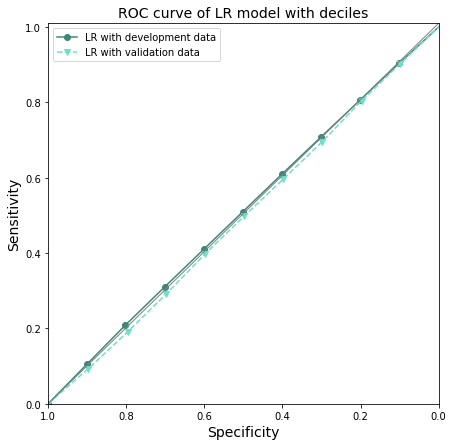

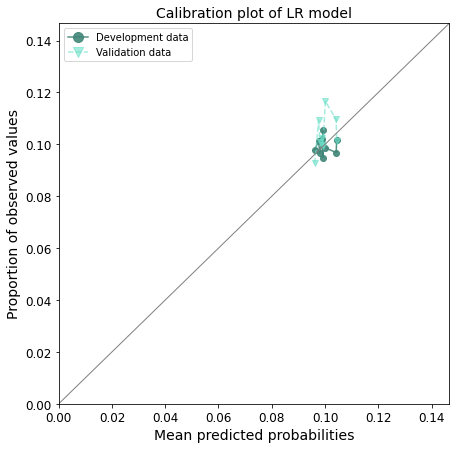


AUROC of LR for risk factors with development and validation data: 0.51563 and 0.51015
LR ORs:
                                  coef  coef_lower  coef_upper       ors  \
age_cat_25_34               -0.074244   -0.080670   -0.067817  0.928446   
age_cat_35_44               -0.035092   -0.041505   -0.028679  0.965517   
age_cat_45_54               -0.013951   -0.020373   -0.007530  0.986145   
age_cat_55_64               -0.066040   -0.072445   -0.059635  0.936093   
age_cat_65_74               -0.047832   -0.054224   -0.041440  0.953294   
age_cat_75_more             -0.083254   -0.089664   -0.076845  0.920117   
sex_male                     0.006279    0.002768    0.009789  1.006298   
CCI_cat_high                 0.008001    0.001134    0.014869  1.008033   
CCI_cat_low                 -0.004611   -0.009665    0.000444  0.995400   
CCI_cat_medium               0.011410    0.005764    0.017055  1.011475   
CCI_cat_very_high            0.042509    0.036562    0.048456  1.043425   
flu

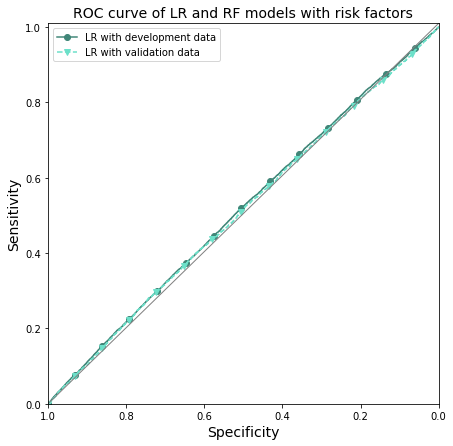

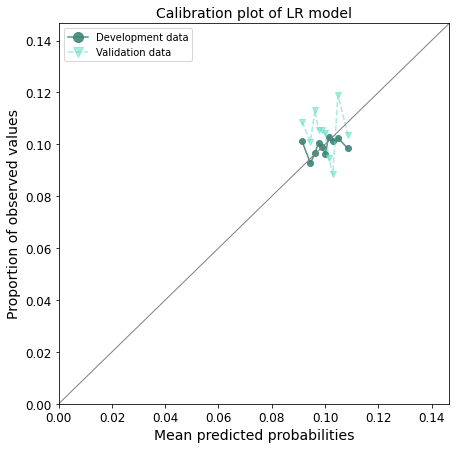

In [267]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_incdt, prob_pred_sinusitis_no_abs_incdt_bin = cox_build('sinusitis', 'incdt', data_sinusitis_incdt, data_sinusitis_no_abs_incdt)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models with deciles as predictors
    prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt = lr_rf_build_risk_deciles('sinusitis', 'incdt_deciles', prob_pred_sinusitis_no_abs_incdt)
    #calibration plots of rf and lr with deciles
    calibration_rf_lr('sinusitis', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt)#, rf_pred_dev_incdt, rf_pred_val_incdt)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

# #make summary table of deciles
# make_summary_table_deciles('sinusitis', 'incdt', prob_pred_enc_lr_rf_incdt)

try:
    #build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
    prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt = lr_rf_build_risk_riskfactors('sinusitis', 'incdt_riskfactors', prob_pred_sinusitis_no_abs_incdt)
    #calibration plots of rf and lr with risk factors
    calibration_rf_lr('sinusitis', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt)#, rf_pred_dev_incdt, rf_pred_val_incdt)
except:
    print("error_3: lr or rf model for risk factors did not converge or failed to finalise or their calibration plot failed.")

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 12219 total observations, 12140 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 12219
number of events observed = 79
   partial log-likelihood = -726.20
         time fit was run = 2023-07-21 17:27:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.09       1.09       0.32            -0.54             0.72                 0.58                 2.05
CCI_cat[T.medium]               -0.14       0.87       0.37            -0.87             0.59                 0.42                 1.81
CCI_cat[T.high]                 -0.36       0.70       0.49            -1.32             0.60                 0.27                 1.82
CCI_cat[T.very_high]            -0.15       0.86       0.39            -0.92             0.62                 0.40                 1.86
age_cat[T.25_34]                -0.02       0.98       0.43            -0.86             0.82                 0.42                 2.27
age_cat[T.35_44]                 0.17       1.19       0.41            -0.63             0.98                 0.53                 2.66
age_cat[T.45_54]                 0.10       1.11       0.42            -0.72             0.92                 0.49                 2.52
age_cat[T.55_64]                -0.03       0.97       0.43            -0.87             0.81                 0.42                 2.24
age_cat[T.65_74]                -0.07       0.93       0.43            -0.91             0.76                 0.40                 2.14
age_cat[T.75_more]              -0.08       0.92       0.44            -0.94             0.77                 0.39                 2.17
antibacterial_brit               0.04       1.04       0.08            -0.12             0.19                 0.89                 1.21
bmi_cat[T.obese]                -0.11       0.90       0.44            -0.97             0.76                 0.38                 2.14
bmi_cat[T.overweight]            0.58       1.78       0.48            -0.37             1.53                 0.69                 4.60
bmi_cat[T.underweight]           0.80       2.23       0.61            -0.39             1.99                 0.68                 7.33
bmi_cat[T.unknown]              -0.01       0.99       0.47            -0.93             0.92                 0.39                 2.50
ethnicity[T.other]               0.73       2.07       0.61            -0.47             1.93                 0.62                 6.88
ethnicity[T.unknown]             0.35       1.42       0.55            -0.73             1.43                 0.48                 4.19
ethnicity[T.white]               0.36       1.43       0.52            -0.66             1.38                 0.52                 3.98
flu_vaccine[T.yes]              -0.67       0.51       0.51            -1.68             0.33                 0.19                 1.40
imd[T.medium]                   -0.18       0.83       0.45            -1.06             0.70                 0.35                 2.02
imd[T.unaffluent]                0.59       1.81       0.38            -0.14             1.33                 0.87                 3.78
imd[T.unknown]                   0.77       2.15       0.51            -0.23             1.76                 0.79                 5.83
imd[T.very_affluent]             0.37       1.44       0.39            -0.40             1.14                 0.67                 3.11
imd[T.very_unaffluent]           0.45       1.57       0.39            -0.31             1.21                 0.73                 3.35
region[T.east_midlands]         -0.15       0.86       0.45           

13047


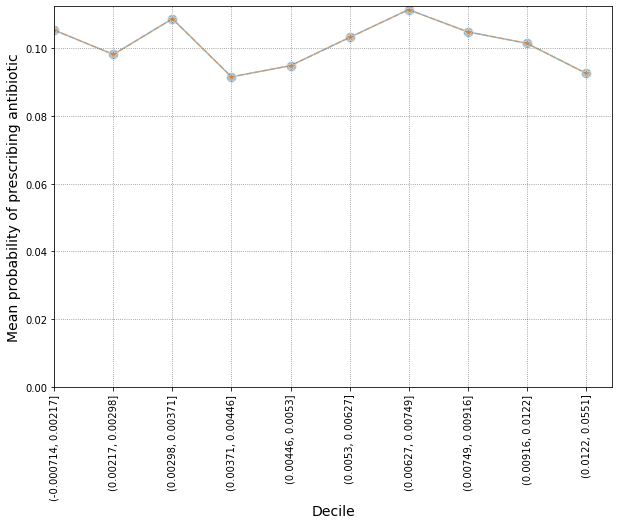


AUROC of LR for deciles with development and validation data: 0.52896 and 0.49388
LR ORs:
                              coef  coef_lower  coef_upper       ors  \
bins_(0.00217, 0.00298] -0.182184   -0.199082   -0.165287  0.833448   
bins_(0.00298, 0.00371]  0.000956   -0.015805    0.017717  1.000956   
bins_(0.00371, 0.00446] -0.246454   -0.263339   -0.229569  0.781567   
bins_(0.00446, 0.0053]  -0.234575   -0.251624   -0.217525  0.790907   
bins_(0.0053, 0.00627]  -0.051184   -0.067837   -0.034532  0.950103   
bins_(0.00627, 0.00749]  0.025621    0.008730    0.042512  1.025952   
bins_(0.00749, 0.00916] -0.008452   -0.025312    0.008408  0.991584   
bins_(0.00916, 0.0122]  -0.107578   -0.124401   -0.090755  0.898006   
bins_(0.0122, 0.0551]   -0.218196   -0.234952   -0.201441  0.803968   

                         ors_lower  ors_upper  
bins_(0.00217, 0.00298]   0.819483   0.847651  
bins_(0.00298, 0.00371]   0.984319   1.017875  
bins_(0.00371, 0.00446]   0.768481   0.794876  
bins_

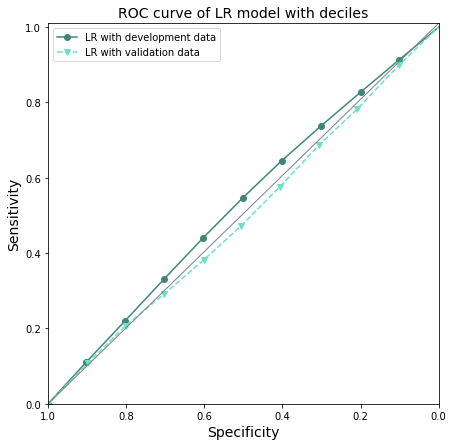

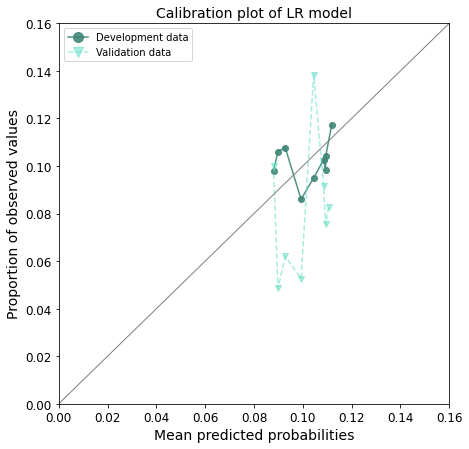


AUROC of LR for risk factors with development and validation data: 0.53358 and 0.46689
LR ORs:
                                  coef  coef_lower  coef_upper       ors  \
age_cat_25_34                0.059918    0.040587    0.079250  1.061750   
age_cat_35_44                0.001405   -0.018046    0.020856  1.001406   
age_cat_45_54                0.054252    0.034623    0.073880  1.055750   
age_cat_55_64               -0.083735   -0.103105   -0.064365  0.919675   
age_cat_65_74                0.178988    0.159687    0.198289  1.196006   
age_cat_75_more              0.113538    0.093959    0.133117  1.120234   
sex_male                    -0.030155   -0.040838   -0.019473  0.970295   
CCI_cat_high                -0.057795   -0.078545   -0.037044  0.943844   
CCI_cat_low                 -0.007258   -0.022662    0.008145  0.992768   
CCI_cat_medium              -0.050451   -0.067696   -0.033205  0.950801   
CCI_cat_very_high            0.017382   -0.000736    0.035499  1.017533   
flu

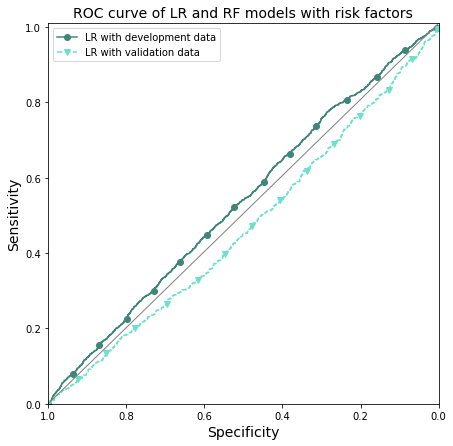

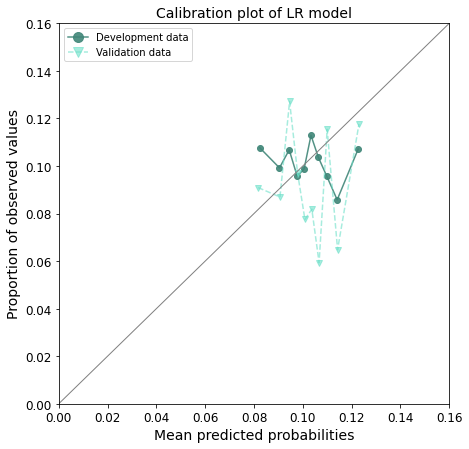

In [269]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_prevl, prob_pred_sinusitis_no_abs_prevl_bin = cox_build('sinusitis', 'prevl', data_sinusitis_prevl, data_sinusitis_no_abs_prevl)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models with deciles as predictors
    prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl = lr_rf_build_risk_deciles('sinusitis', 'prevl_deciles', prob_pred_sinusitis_no_abs_prevl)
    #calibration plots of rf and lr with deciles
    calibration_rf_lr('sinusitis', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl)#, rf_pred_dev_prevl, rf_pred_val_prevl)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

# #make summary table of deciles
# make_summary_table_deciles('sinusitis', 'prevl', prob_pred_enc_lr_rf_prevl)

# try:
    #build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
    prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl = lr_rf_build_risk_riskfactors('sinusitis', 'prevl_riskfactors', prob_pred_sinusitis_no_abs_prevl)
    #calibration plots of rf and lr with risk factors
    calibration_rf_lr('sinusitis', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl)#, rf_pred_dev_prevl, rf_pred_val_prevl)
except:
    print("error_3: lr or rf model for risk factors did not converge or failed to finalise or their calibration plot failed.")

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 28560 total observations, 28405 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 28560
number of events observed = 155
   partial log-likelihood = -1560.79
         time fit was run = 2023-07-21 17:27:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.89       0.23            -0.57             0.33                 0.56                 1.40
CCI_cat[T.medium]                0.02       1.02       0.25            -0.47             0.51                 0.63                 1.66
CCI_cat[T.high]                 -1.12       0.33       0.45            -2.00            -0.24                 0.14                 0.78
CCI_cat[T.very_high]             0.06       1.06       0.26            -0.44             0.57                 0.64                 1.77
age_cat[T.25_34]                 0.07       1.07       0.30            -0.51             0.66                 0.60                 1.93
age_cat[T.35_44]                -0.04       0.96       0.31            -0.64             0.56                 0.53                 1.75
age_cat[T.45_54]                 0.01       1.01       0.30            -0.58             0.60                 0.56                 1.83
age_cat[T.55_64]                -0.19       0.82       0.32            -0.82             0.43                 0.44                 1.54
age_cat[T.65_74]                -0.38       0.68       0.34            -1.04             0.28                 0.35                 1.32
age_cat[T.75_more]               0.47       1.60       0.27            -0.07             1.01                 0.93                 2.73
antibacterial_brit              -0.00       1.00       0.06            -0.11             0.11                 0.89                 1.11
bmi_cat[T.obese]                 0.01       1.01       0.29            -0.56             0.57                 0.57                 1.78
bmi_cat[T.overweight]           -0.09       0.91       0.37            -0.81             0.63                 0.44                 1.87
bmi_cat[T.underweight]           0.50       1.65       0.43            -0.34             1.34                 0.71                 3.81
bmi_cat[T.unknown]              -0.30       0.74       0.32            -0.94             0.33                 0.39                 1.39
ethnicity[T.other]               0.22       1.24       0.42            -0.61             1.04                 0.54                 2.83
ethnicity[T.unknown]             0.35       1.42       0.35            -0.33             1.03                 0.72                 2.80
ethnicity[T.white]              -0.00       1.00       0.34            -0.66             0.66                 0.52                 1.93
flu_vaccine[T.yes]               0.49       1.63       0.23             0.04             0.94                 1.04                 2.56
imd[T.medium]                   -0.13       0.88       0.23            -0.58             0.32                 0.56                 1.38
imd[T.unaffluent]               -0.43       0.65       0.25            -0.93             0.06                 0.40                 1.06
imd[T.unknown]                  -0.28       0.75       0.39            -1.04             0.48                 0.35                 1.61
imd[T.very_affluent]            -0.67       0.51       0.27            -1.20            -0.14                 0.30                 0.87
imd[T.very_unaffluent]          -0.52       0.60       0.26            -1.03            -0.01                 0.36                 0.99
region[T.east_midlands]         -0.08       0.92       0.40         

13048


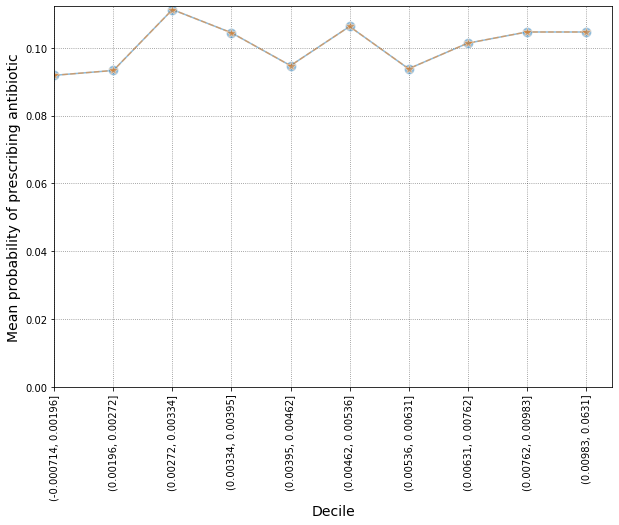


AUROC of LR for deciles with development and validation data: 0.52291 and 0.50602
LR ORs:
                              coef  coef_lower  coef_upper       ors  \
bins_(0.00196, 0.00272]  0.053685    0.042618    0.064751  1.055152   
bins_(0.00272, 0.00334]  0.228998    0.217987    0.240009  1.257339   
bins_(0.00334, 0.00395]  0.161382    0.150430    0.172335  1.175134   
bins_(0.00395, 0.00462]  0.038586    0.027651    0.049522  1.039341   
bins_(0.00462, 0.00536]  0.230893    0.219777    0.242010  1.259724   
bins_(0.00536, 0.00631]  0.057240    0.046248    0.068232  1.058910   
bins_(0.00631, 0.00762]  0.130927    0.119922    0.141931  1.139884   
bins_(0.00762, 0.00983]  0.215108    0.204117    0.226098  1.239996   
bins_(0.00983, 0.0631]   0.146229    0.135183    0.157274  1.157461   

                         ors_lower  ors_upper  
bins_(0.00196, 0.00272]   1.043539   1.066894  
bins_(0.00272, 0.00334]   1.243571   1.271260  
bins_(0.00334, 0.00395]   1.162334   1.188076  
bins_

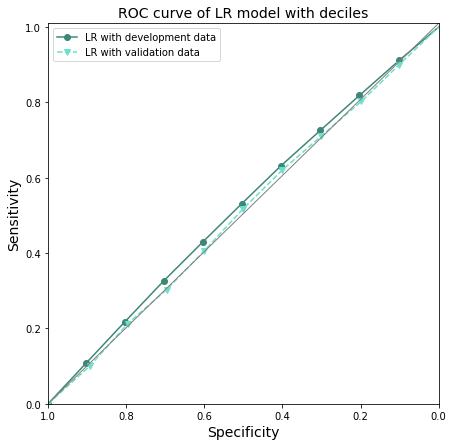

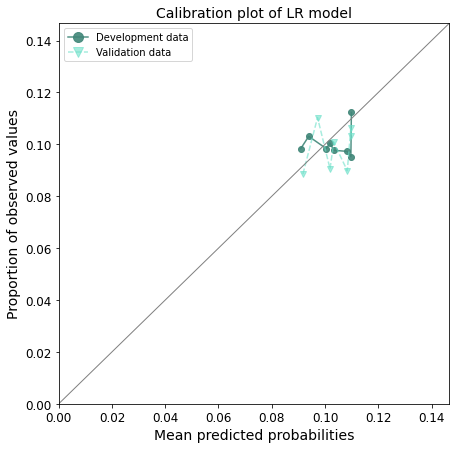

In [270]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_incdt_prepandemic, prob_pred_sinusitis_no_abs_incdt_prepandemic_bin = cox_build('sinusitis', 'incdt_prepandemic', data_sinusitis_incdt_prepandemic, data_sinusitis_no_abs_incdt_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic = lr_rf_build_risk_deciles('sinusitis', 'incdt_prepandemic_deciles', prob_pred_sinusitis_no_abs_incdt_prepandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('sinusitis', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic)#, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 26088 total observations, 25926 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 26088
number of events observed = 162
   partial log-likelihood = -1631.43
         time fit was run = 2023-07-21 17:28:04 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.34       0.71       0.24            -0.80             0.13                 0.45                 1.14
CCI_cat[T.medium]               -0.05       0.95       0.25            -0.54             0.45                 0.58                 1.56
CCI_cat[T.high]                  0.19       1.21       0.28            -0.36             0.75                 0.69                 2.11
CCI_cat[T.very_high]             0.01       1.01       0.26            -0.49             0.52                 0.61                 1.68
age_cat[T.25_34]                -0.21       0.81       0.28            -0.76             0.35                 0.47                 1.41
age_cat[T.35_44]                -0.31       0.73       0.29            -0.88             0.26                 0.42                 1.29
age_cat[T.45_54]                -0.39       0.68       0.29            -0.96             0.19                 0.38                 1.20
age_cat[T.55_64]                -0.58       0.56       0.31            -1.20             0.03                 0.30                 1.03
age_cat[T.65_74]                -0.06       0.94       0.27            -0.58             0.47                 0.56                 1.59
age_cat[T.75_more]              -0.11       0.90       0.27            -0.64             0.43                 0.53                 1.53
antibacterial_brit              -0.06       0.94       0.06            -0.17             0.05                 0.84                 1.06
bmi_cat[T.obese]                 0.41       1.51       0.35            -0.27             1.10                 0.76                 3.00
bmi_cat[T.overweight]            0.26       1.30       0.42            -0.55             1.08                 0.57                 2.95
bmi_cat[T.underweight]           0.51       1.66       0.53            -0.53             1.54                 0.59                 4.68
bmi_cat[T.unknown]               0.31       1.37       0.37            -0.41             1.04                 0.66                 2.82
ethnicity[T.other]               0.53       1.70       0.44            -0.34             1.40                 0.71                 4.06
ethnicity[T.unknown]             0.38       1.46       0.39            -0.38             1.14                 0.68                 3.12
ethnicity[T.white]               0.42       1.52       0.37            -0.30             1.14                 0.74                 3.13
flu_vaccine[T.yes]              -0.20       0.82       0.29            -0.77             0.36                 0.46                 1.44
imd[T.medium]                   -0.01       0.99       0.25            -0.49             0.47                 0.61                 1.61
imd[T.unaffluent]               -0.08       0.93       0.25            -0.57             0.42                 0.57                 1.52
imd[T.unknown]                  -0.32       0.73       0.44            -1.19             0.55                 0.30                 1.73
imd[T.very_affluent]            -0.12       0.88       0.25            -0.62             0.37                 0.54                 1.45
imd[T.very_unaffluent]          -0.06       0.94       0.25            -0.55             0.43                 0.58                 1.54
region[T.east_midlands]          0.34       1.40       0.34         

13046


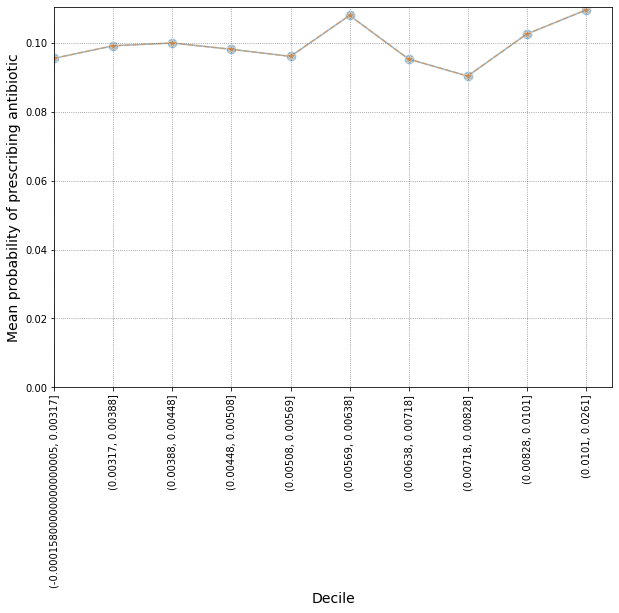


AUROC of LR for deciles with development and validation data: 0.51938 and 0.50823
LR ORs:
                              coef  coef_lower  coef_upper       ors  \
bins_(0.00317, 0.00388]  0.125769    0.114084    0.137454  1.134020   
bins_(0.00388, 0.00448]  0.074844    0.063346    0.086342  1.077716   
bins_(0.00448, 0.00508]  0.050914    0.039540    0.062288  1.052232   
bins_(0.00508, 0.00569]  0.040403    0.028843    0.051962  1.041230   
bins_(0.00569, 0.00638]  0.177116    0.165560    0.188671  1.193769   
bins_(0.00638, 0.00718]  0.042413    0.030864    0.053963  1.043325   
bins_(0.00718, 0.00828] -0.026618   -0.038274   -0.014961  0.973733   
bins_(0.00828, 0.0101]   0.108381    0.096825    0.119936  1.114472   
bins_(0.0101, 0.0261]    0.189963    0.178414    0.201513  1.209205   

                         ors_lower  ors_upper  
bins_(0.00317, 0.00388]   1.120846   1.147349  
bins_(0.00388, 0.00448]   1.065396   1.090180  
bins_(0.00448, 0.00508]   1.040332   1.064269  
bins_

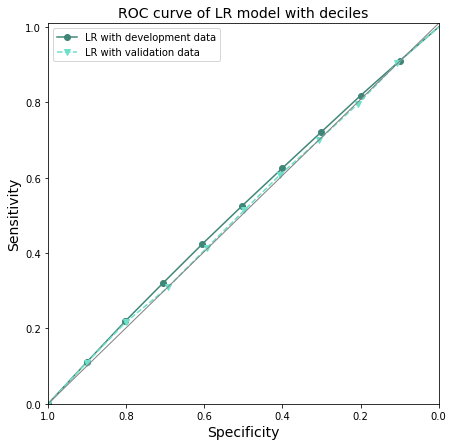

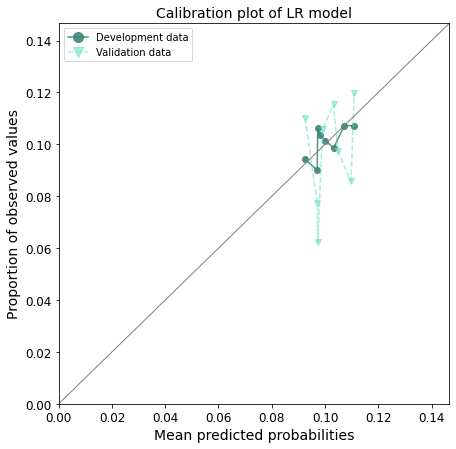

In [271]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_incdt_during_pandemic, prob_pred_sinusitis_no_abs_incdt_during_pandemic_bin = cox_build('sinusitis', 'incdt_during_pandemic', data_sinusitis_incdt_during_pandemic, data_sinusitis_no_abs_incdt_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic = lr_rf_build_risk_deciles('sinusitis', 'incdt_during_pandemic_deciles', prob_pred_sinusitis_no_abs_incdt_during_pandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('sinusitis', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic)#, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 46158 total observations, 45837 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 46158
number of events observed = 321
   partial log-likelihood = -3426.76
         time fit was run = 2023-07-21 17:28:13 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.07       1.07       0.17            -0.26             0.39                 0.77                 1.48
CCI_cat[T.medium]                0.14       1.15       0.18            -0.22             0.49                 0.80                 1.64
CCI_cat[T.high]                 -0.31       0.74       0.25            -0.80             0.19                 0.45                 1.20
CCI_cat[T.very_high]             0.06       1.06       0.19            -0.32             0.44                 0.73                 1.55
age_cat[T.25_34]                -0.09       0.91       0.20            -0.49             0.31                 0.61                 1.36
age_cat[T.35_44]                 0.07       1.07       0.20            -0.32             0.46                 0.73                 1.58
age_cat[T.45_54]                -0.07       0.93       0.21            -0.48             0.33                 0.62                 1.39
age_cat[T.55_64]                -0.24       0.79       0.21            -0.66             0.18                 0.52                 1.20
age_cat[T.65_74]                -0.10       0.90       0.21            -0.50             0.30                 0.60                 1.35
age_cat[T.75_more]              -0.23       0.79       0.21            -0.65             0.18                 0.52                 1.20
antibacterial_brit               0.08       1.08       0.04             0.00             0.15                 1.00                 1.16
bmi_cat[T.obese]                 0.12       1.13       0.21            -0.29             0.54                 0.75                 1.71
bmi_cat[T.overweight]           -0.11       0.90       0.27            -0.64             0.42                 0.53                 1.52
bmi_cat[T.underweight]          -0.10       0.90       0.39            -0.86             0.66                 0.42                 1.93
bmi_cat[T.unknown]               0.01       1.01       0.23            -0.43             0.46                 0.65                 1.58
ethnicity[T.other]              -0.03       0.97       0.28            -0.58             0.52                 0.56                 1.68
ethnicity[T.unknown]            -0.03       0.97       0.23            -0.47             0.41                 0.63                 1.51
ethnicity[T.white]              -0.07       0.93       0.21            -0.48             0.34                 0.62                 1.40
flu_vaccine[T.yes]               0.22       1.24       0.17            -0.12             0.56                 0.88                 1.74
imd[T.medium]                    0.13       1.14       0.18            -0.22             0.48                 0.80                 1.62
imd[T.unaffluent]                0.14       1.15       0.18            -0.22             0.49                 0.81                 1.63
imd[T.unknown]                  -0.31       0.73       0.33            -0.95             0.34                 0.39                 1.40
imd[T.very_affluent]             0.06       1.06       0.18            -0.30             0.42                 0.74                 1.52
imd[T.very_unaffluent]          -0.02       0.98       0.19            -0.38             0.35                 0.68                 1.42
region[T.east_midlands]         -0.22       0.80       0.24         

13052


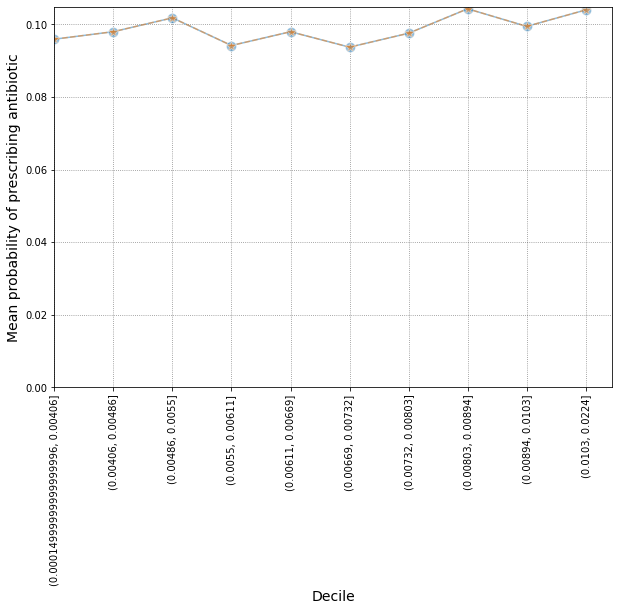


AUROC of LR for deciles with development and validation data: 0.51535 and 0.49404
LR ORs:
                              coef  coef_lower  coef_upper       ors  \
bins_(0.00406, 0.00486] -0.010802   -0.019454   -0.002150  0.989256   
bins_(0.00486, 0.0055]   0.048270    0.039630    0.056910  1.049454   
bins_(0.0055, 0.00611]  -0.072728   -0.081393   -0.064063  0.929854   
bins_(0.00611, 0.00669]  0.026554    0.017917    0.035192  1.026910   
bins_(0.00669, 0.00732] -0.080482   -0.089163   -0.071802  0.922671   
bins_(0.00732, 0.00803] -0.037308   -0.045969   -0.028647  0.963379   
bins_(0.00803, 0.00894]  0.086652    0.077983    0.095320  1.090517   
bins_(0.00894, 0.0103]  -0.000074   -0.008717    0.008568  0.999926   
bins_(0.0103, 0.0224]    0.073842    0.065207    0.082477  1.076636   

                         ors_lower  ors_upper  
bins_(0.00406, 0.00486]   0.980734   0.997852  
bins_(0.00486, 0.0055]    1.040426   1.058560  
bins_(0.0055, 0.00611]    0.921831   0.937946  
bins_

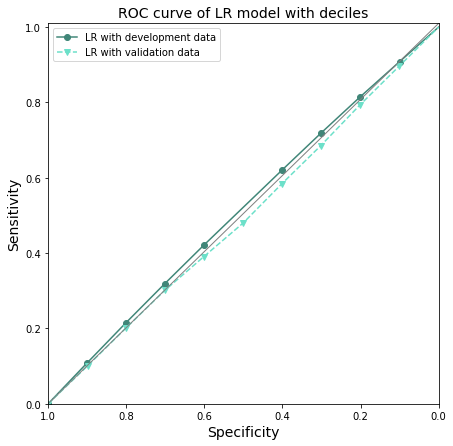

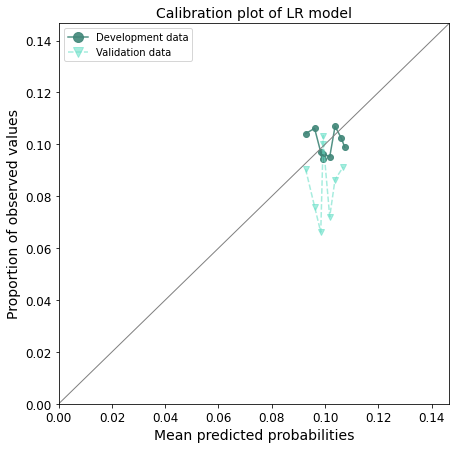

In [272]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_incdt_post_2nd_lockdown, prob_pred_sinusitis_no_abs_incdt_post_2nd_lockdown_bin = cox_build('sinusitis', 'incdt_post_2nd_lockdown', data_sinusitis_incdt_post_2nd_lockdown, data_sinusitis_no_abs_incdt_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk_deciles('sinusitis', 'incdt_post_2nd_lockdown_deciles', prob_pred_sinusitis_no_abs_incdt_post_2nd_lockdown)
    #calibration plots of rf and lr
    calibration_rf_lr('sinusitis', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown)#, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 3235 total observations, 3210 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 3235
number of events observed = 25
   partial log-likelihood = -183.05
         time fit was run = 2023-07-21 17:28:30 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.35       1.42       0.53            -0.68             1.38                 0.51                 3.99
CCI_cat[T.medium]               -0.13       0.88       0.64            -1.38             1.12                 0.25                 3.08
CCI_cat[T.high]                 -1.16       0.31       1.10            -3.32             0.99                 0.04                 2.70
CCI_cat[T.very_high]           -18.18       0.00    3890.17         -7642.77          7606.42                 0.00                  inf
age_cat[T.25_34]                -0.87       0.42       0.84            -2.52             0.79                 0.08                 2.20
age_cat[T.35_44]                -1.64       0.19       1.10            -3.80             0.52                 0.02                 1.69
age_cat[T.45_54]                 0.23       1.25       0.62            -0.98             1.43                 0.37                 4.20
age_cat[T.55_64]                 0.04       1.04       0.64            -1.22             1.30                 0.29                 3.67
age_cat[T.65_74]                -0.50       0.61       0.74            -1.94             0.95                 0.14                 2.58
age_cat[T.75_more]              -0.55       0.58       0.74            -2.00             0.90                 0.13                 2.46
antibacterial_brit               0.11       1.12       0.14            -0.16             0.38                 0.85                 1.47
bmi_cat[T.obese]                -0.94       0.39       0.61            -2.13             0.25                 0.12                 1.28
bmi_cat[T.overweight]           -0.12       0.88       0.72            -1.53             1.28                 0.22                 3.60
bmi_cat[T.underweight]         -18.56       0.00    8256.55        -16201.10         16163.98                 0.00                  inf
bmi_cat[T.unknown]              -0.56       0.57       0.64            -1.81             0.69                 0.16                 2.00
ethnicity[T.other]              17.89   5.87e+07    5564.30        -10887.94         10923.72                 0.00                  inf
ethnicity[T.unknown]            17.88   5.80e+07    5564.30        -10887.95         10923.70                 0.00                  inf
ethnicity[T.white]              17.80   5.39e+07    5564.30        -10888.03         10923.63                 0.00                  inf
flu_vaccine[T.yes]              -0.76       0.47       1.03            -2.78             1.26                 0.06                 3.52
imd[T.medium]                    0.27       1.31       0.77            -1.24             1.79                 0.29                 5.96
imd[T.unaffluent]                0.70       2.01       0.71            -0.70             2.10                 0.50                 8.14
imd[T.unknown]                   0.29       1.33       1.17            -2.00             2.57                 0.14                13.11
imd[T.very_affluent]             0.72       2.06       0.72            -0.68             2.13                 0.51                 8.38
imd[T.very_unaffluent]           0.54       1.71       0.74            -0.91             1.99                 0.40                 7.28
region[T.east_midlands]          0.25       1.29       0.77            -1

13109


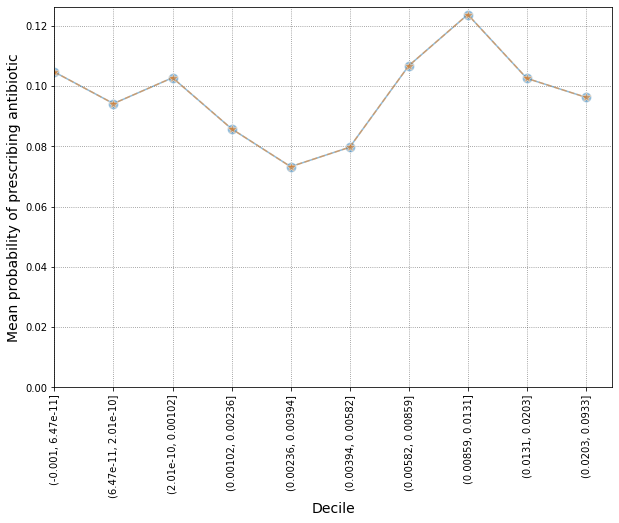


AUROC of LR for deciles with development and validation data: 0.53495 and 0.54553
LR ORs:
                                coef  coef_lower  coef_upper       ors  \
bins_(0.00102, 0.00236]   -0.079685   -0.111292   -0.048077  0.923408   
bins_(0.00236, 0.00394]   -0.179856   -0.212136   -0.147577  0.835390   
bins_(0.00394, 0.00582]   -0.050260   -0.082311   -0.018210  0.950982   
bins_(0.00582, 0.00859]    0.138277    0.106670    0.169884  1.148293   
bins_(0.00859, 0.0131]     0.302766    0.271116    0.334417  1.353598   
bins_(0.0131, 0.0203]     -0.031488   -0.063315    0.000338  0.969002   
bins_(0.0203, 0.0933]      0.054186    0.022044    0.086327  1.055680   
bins_(2.01e-10, 0.00102]   0.036090    0.004219    0.067961  1.036749   
bins_(6.47e-11, 2.01e-10]  0.037681    0.006246    0.069116  1.038399   

                           ors_lower  ors_upper  
bins_(0.00102, 0.00236]     0.894678   0.953060  
bins_(0.00236, 0.00394]     0.808855   0.862796  
bins_(0.00394, 0.00582]    

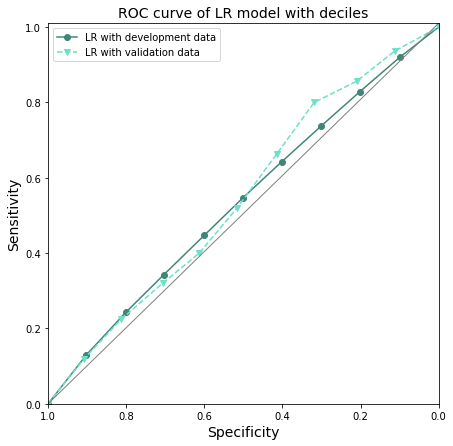

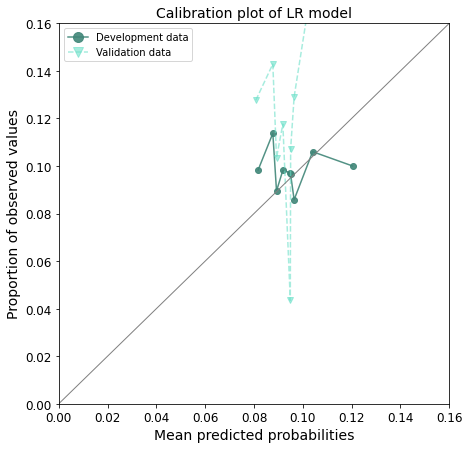

In [273]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_prevl_prepandemic, prob_pred_sinusitis_no_abs_prevl_prepandemic_bin = cox_build('sinusitis', 'prevl_prepandemic', data_sinusitis_prevl_prepandemic, data_sinusitis_no_abs_prevl_prepandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic = lr_rf_build_risk_deciles('sinusitis', 'prevl_prepandemic_deciles', prob_pred_sinusitis_no_abs_prevl_prepandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('sinusitis', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic)#, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 2837 total observations, 2824 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 2837
number of events observed = 13
   partial log-likelihood = -87.36
         time fit was run = 2023-07-21 17:28:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.91       2.48       1.14            -1.32             3.14                 0.27                23.16
CCI_cat[T.medium]                1.70       5.50       1.10            -0.46             3.87                 0.63                47.72
CCI_cat[T.high]                  1.21       3.36       1.25            -1.23             3.66                 0.29                38.82
CCI_cat[T.very_high]           -17.20       0.00    5890.95        -11563.26         11528.86                 0.00                  inf
age_cat[T.25_34]                -0.47       0.63       1.45            -3.31             2.38                 0.04                10.79
age_cat[T.35_44]                -0.23       0.80       1.44            -3.04             2.59                 0.05                13.30
age_cat[T.45_54]                 0.52       1.67       1.25            -1.93             2.96                 0.15                19.24
age_cat[T.55_64]                 0.63       1.88       1.24            -1.80             3.06                 0.17                21.29
age_cat[T.65_74]                 0.77       2.17       1.18            -1.54             3.08                 0.22                21.80
age_cat[T.75_more]               1.20       3.30       1.17            -1.09             3.48                 0.33                32.62
antibacterial_brit               0.23       1.26       0.19            -0.15             0.60                 0.86                 1.83
bmi_cat[T.obese]                18.02   6.72e+07    8621.11        -16879.04         16915.08                 0.00                  inf
bmi_cat[T.overweight]           18.19   7.97e+07    8621.11        -16878.87         16915.25                 0.00                  inf
bmi_cat[T.underweight]          18.92   1.64e+08    8621.11        -16878.14         16915.98                 0.00                  inf
bmi_cat[T.unknown]              18.06   7.01e+07    8621.11        -16878.99         16915.12                 0.00                  inf
ethnicity[T.other]               0.53       1.69       1.25            -1.93             2.98                 0.14                19.75
ethnicity[T.unknown]            -0.73       0.48       1.44            -3.54             2.09                 0.03                 8.10
ethnicity[T.white]               0.27       1.32       1.07            -1.83             2.38                 0.16                10.80
flu_vaccine[T.yes]              -0.05       0.95       1.07            -2.15             2.04                 0.12                 7.73
imd[T.medium]                    0.82       2.28       1.24            -1.61             3.26                 0.20                26.01
imd[T.unaffluent]                0.68       1.98       1.24            -1.74             3.11                 0.18                22.37
imd[T.unknown]                   2.67      14.46       1.18             0.35             4.99                 1.42               146.79
imd[T.very_affluent]             1.11       3.02       1.17            -1.18             3.40                 0.31                29.84
imd[T.very_unaffluent]           0.97       2.63       1.24            -1.47             3.40                 0.23                29.83
region[T.east_midlands]          0.31       1.37       1.43            -2.

13169


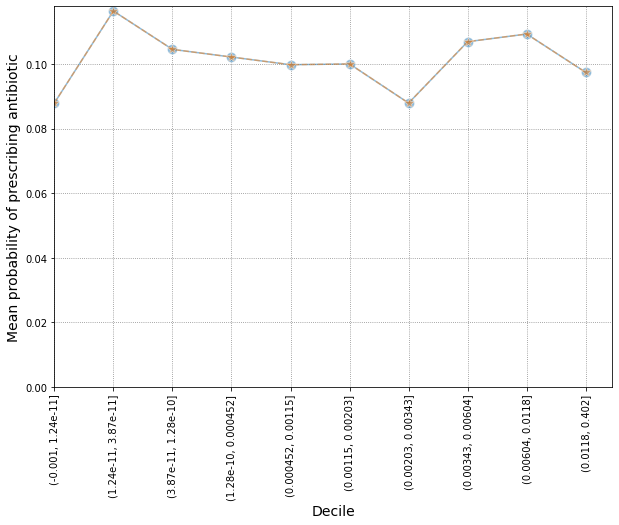


AUROC of LR for deciles with development and validation data: 0.53857 and 0.46062
LR ORs:
                                coef  coef_lower  coef_upper       ors  \
bins_(0.000452, 0.00115]   0.152681    0.117184    0.188178  1.164953   
bins_(0.00115, 0.00203]    0.162910    0.127245    0.198576  1.176931   
bins_(0.00203, 0.00343]    0.112576    0.076624    0.148528  1.119157   
bins_(0.00343, 0.00604]    0.205767    0.169930    0.241603  1.228467   
bins_(0.00604, 0.0118]     0.350332    0.314610    0.386054  1.419539   
bins_(0.0118, 0.402]       0.088663    0.053111    0.124216  1.092713   
bins_(1.24e-11, 3.87e-11]  0.350759    0.315484    0.386035  1.420145   
bins_(1.28e-10, 0.000452] -0.080678   -0.116515   -0.044841  0.922491   
bins_(3.87e-11, 1.28e-10]  0.181714    0.146273    0.217155  1.199271   

                           ors_lower  ors_upper  
bins_(0.000452, 0.00115]    1.124326   1.207048  
bins_(0.00115, 0.00203]     1.135695   1.219664  
bins_(0.00203, 0.00343]    

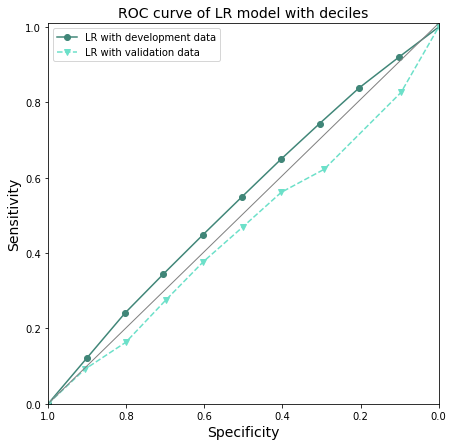

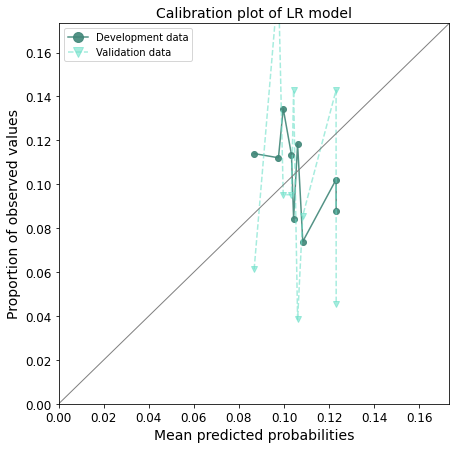

In [274]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_prevl_during_pandemic, prob_pred_sinusitis_no_abs_prevl_during_pandemic_bin = cox_build('sinusitis', 'prevl_during_pandemic', data_sinusitis_prevl_during_pandemic, data_sinusitis_no_abs_prevl_during_pandemic)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic = lr_rf_build_risk_deciles('sinusitis', 'prevl_during_pandemic_deciles', prob_pred_sinusitis_no_abs_prevl_during_pandemic)
    #calibration plots of rf and lr
    calibration_rf_lr('sinusitis', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic)#, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")

<lifelines.CoxPHFitter: fitted with 5148 total observations, 5114 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 5148
number of events observed = 34
   partial log-likelihood = -266.94
         time fit was run = 2023-07-21 17:28:50 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.06       1.06       0.54            -1.00             1.11                 0.37                 3.04
CCI_cat[T.medium]                0.40       1.49       0.56            -0.69             1.49                 0.50                 4.43
CCI_cat[T.high]                 -0.43       0.65       0.84            -2.08             1.22                 0.12                 3.37
CCI_cat[T.very_high]            -0.00       1.00       0.64            -1.25             1.25                 0.29                 3.49
age_cat[T.25_34]                 0.82       2.28       0.62            -0.38             2.03                 0.68                 7.63
age_cat[T.35_44]                 0.93       2.53       0.61            -0.26             2.12                 0.77                 8.32
age_cat[T.45_54]                -0.59       0.56       0.87            -2.29             1.12                 0.10                 3.06
age_cat[T.55_64]                 0.06       1.06       0.71            -1.34             1.45                 0.26                 4.28
age_cat[T.65_74]                -0.24       0.79       0.77            -1.75             1.26                 0.17                 3.54
age_cat[T.75_more]               0.09       1.10       0.71            -1.30             1.49                 0.27                 4.42
antibacterial_brit               0.02       1.02       0.12            -0.22             0.25                 0.80                 1.29
bmi_cat[T.obese]                 0.92       2.51       1.04            -1.12             2.95                 0.33                19.15
bmi_cat[T.overweight]            1.82       6.19       1.07            -0.27             3.91                 0.77                49.92
bmi_cat[T.underweight]           2.52      12.41       1.13             0.31             4.73                 1.36               112.96
bmi_cat[T.unknown]               0.99       2.68       1.07            -1.12             3.09                 0.33                21.94
ethnicity[T.other]               0.96       2.60       1.17            -1.33             3.24                 0.27                25.56
ethnicity[T.unknown]             1.16       3.20       1.06            -0.91             3.24                 0.40                25.50
ethnicity[T.white]               1.05       2.85       1.03            -0.96             3.06                 0.38                21.35
flu_vaccine[T.yes]               0.30       1.35       0.54            -0.76             1.37                 0.47                 3.92
imd[T.medium]                   -1.09       0.34       0.59            -2.25             0.06                 0.11                 1.06
imd[T.unaffluent]               -0.70       0.50       0.51            -1.70             0.31                 0.18                 1.36
imd[T.unknown]                  -0.95       0.39       1.05            -3.01             1.11                 0.05                 3.04
imd[T.very_affluent]            -0.87       0.42       0.54            -1.94             0.20                 0.14                 1.22
imd[T.very_unaffluent]          -0.43       0.65       0.49            -1.39             0.53                 0.25                 1.70
region[T.east_midlands]         -0.24       0.78       0.77            -1

13082


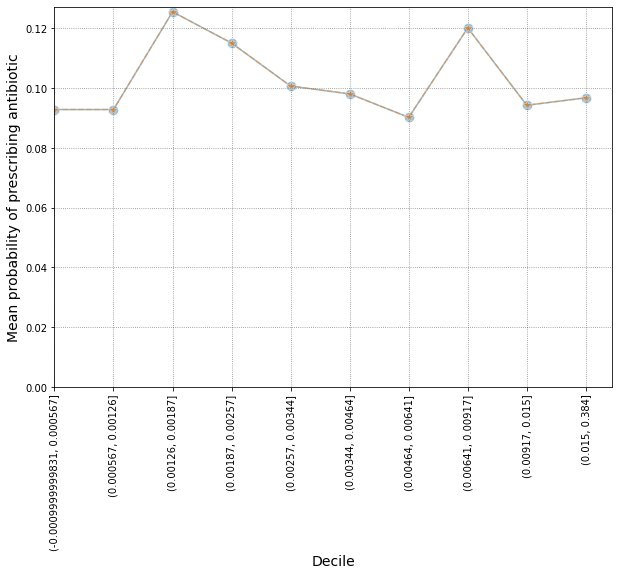


AUROC of LR for deciles with development and validation data: 0.54390 and 0.49162
LR ORs:
                               coef  coef_lower  coef_upper       ors  \
bins_(0.000567, 0.00126]  0.148467    0.122051    0.174883  1.160055   
bins_(0.00126, 0.00187]   0.472233    0.445654    0.498812  1.603571   
bins_(0.00187, 0.00257]   0.335378    0.308893    0.361864  1.398469   
bins_(0.00257, 0.00344]   0.159889    0.133334    0.186444  1.173381   
bins_(0.00344, 0.00464]   0.147935    0.121286    0.174584  1.159438   
bins_(0.00464, 0.00641]   0.099586    0.073284    0.125888  1.104714   
bins_(0.00641, 0.00917]   0.434957    0.408989    0.460925  1.544897   
bins_(0.00917, 0.015]     0.246016    0.219554    0.272478  1.278920   
bins_(0.015, 0.384]       0.096283    0.069775    0.122792  1.101071   

                          ors_lower  ors_upper  
bins_(0.000567, 0.00126]   1.129812   1.191107  
bins_(0.00126, 0.00187]    1.561511   1.646763  
bins_(0.00187, 0.00257]    1.361916   1.

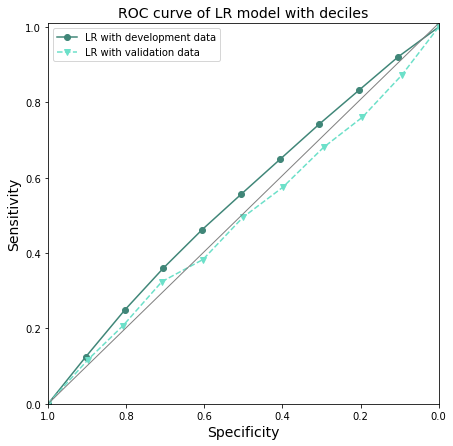

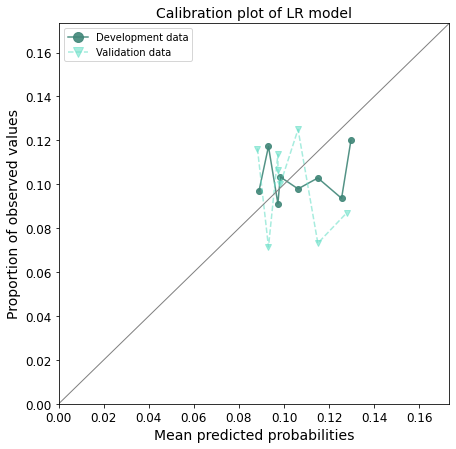

In [275]:
try:
    #build cox model for hosp prediction using non ab users' data
    prob_pred_sinusitis_no_abs_prevl_post_2nd_lockdown, prob_pred_sinusitis_no_abs_prevl_post_2nd_lockdown_bin = cox_build('sinusitis', 'prevl_post_2nd_lockdown', data_sinusitis_prevl_post_2nd_lockdown, data_sinusitis_no_abs_prevl_post_2nd_lockdown)
except:
    print("error_1: cox model did not converge or failed to finalise.")

try:
    #build rf and lr models
    prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk_deciles('sinusitis', 'prevl_post_2nd_lockdown_deciles', prob_pred_sinusitis_no_abs_prevl_post_2nd_lockdown)
    #calibration plots of rf and lr
    calibration_rf_lr('sinusitis', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown)#, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)
except:
    print("error_2: lr or rf model for deciles did not converge or failed to finalise or their calibration plot failed.")